In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/709

/content/drive/MyDrive/709


In [3]:
ls

Ass1/  Ass2/  W10/  W11/  W14/  W8/  W9/


In [4]:
cd Ass2/

/content/drive/MyDrive/709/Ass2


In [5]:
!pip install pyspark

In [6]:
# Step 2: Import necessary modules
#from pyspark import SparkConf, SparkContext
#from pyspark.sql import SparkSession

In [7]:
# Step 2: Set up the Spark environment
#conf = SparkConf().setAppName("709Reduce")
#sc = SparkContext(conf=conf)
#spark = SparkSession(sc)  # Create a SparkSession

In [8]:
# Step 2: Import necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, format_number, to_date

spark = SparkSession.builder \
    .appName("709Reduce") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

In [9]:
# Step 3: Read file
df = spark.read.csv('gold1.csv', header=True, inferSchema=True)
df.show()

+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+
|      Date| Open| High|  Low|Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA|LongMA|Volatility|DayOfWeek|
+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+
|2000-01-04|289.5|289.5|280.0|283.7| 21621|       9.5|      0.0|         0.0|  283.7| 283.7|       0.0|  Tuesday|
|2000-01-05|283.7|285.0|281.0|282.1| 25448|       4.0| -0.00566|       -0.56|  282.9| 282.9|      1.13|Wednesday|
|2000-01-06|281.6|282.8|280.2|282.4| 19055|       2.6|  0.00106|        0.11| 282.73|282.73|      0.85| Thursday|
|2000-01-07|282.5|284.5|282.0|282.9| 11266|       2.5|  0.00177|        0.18| 282.78|282.78|       0.7|   Friday|
|2000-01-10|282.4|283.9|281.8|282.7| 30603|       2.1|  -7.1E-4|       -0.07| 282.76|282.76|      0.61|   Monday|
|2000-01-11|282.4|285.3|281.9|284.4| 13500|       3.4|    0.006|         0.6| 283.03|283

In [10]:
from pyspark.sql import functions as F

# Check Null Value
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+
|Date|Open|High|Low|Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA|LongMA|Volatility|DayOfWeek|
+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+
|   0|   0|   0|  0|    0|     0|         0|        0|           0|      0|     0|         0|        0|
+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+



In [11]:
rows =df.count()
print("Number of rows:", rows)
cols=len(df.columns)
print("Number of columns:", cols)

Number of rows: 5701
Number of columns: 13


In [13]:
from pyspark.sql.functions import year, col

# Step 4: Extract the year from the Date column

df = df.withColumn("Date", col("Date").cast("date"))
df_with_year = df.withColumn("Year", year(col("Date")))

# Now group by the "Year" column and count the number of records for each year
yearly_counts = df_with_year.groupBy("Year").count().orderBy("Year")

# Show the result
yearly_counts.show(23)

+----+-----+
|Year|count|
+----+-----+
|2000|  249|
|2001|  248|
|2002|  250|
|2003|  250|
|2004|  249|
|2005|  251|
|2006|  251|
|2007|  256|
|2008|  255|
|2009|  252|
|2010|  252|
|2011|  252|
|2012|  252|
|2013|  252|
|2014|  252|
|2015|  252|
|2016|  252|
|2017|  251|
|2018|  252|
|2019|  251|
|2020|  253|
|2021|  252|
|2022|  167|
+----+-----+



In [14]:
# Step 5: Repartition without specifying the column, this ensures even distribution across partitions
df_partitioned = df.repartition(22)

# Check the number of records in each partition after repartitioning
partitions_data = df_partitioned.rdd.glom().collect()
for i, partition in enumerate(partitions_data):
    print(f"Partition {i} has {len(partition)} records")

# Show the result to verify
df_partitioned.show(23)

Partition 0 has 259 records
Partition 1 has 259 records
Partition 2 has 259 records
Partition 3 has 259 records
Partition 4 has 259 records
Partition 5 has 259 records
Partition 6 has 259 records
Partition 7 has 259 records
Partition 8 has 259 records
Partition 9 has 259 records
Partition 10 has 259 records
Partition 11 has 259 records
Partition 12 has 259 records
Partition 13 has 259 records
Partition 14 has 259 records
Partition 15 has 260 records
Partition 16 has 260 records
Partition 17 has 260 records
Partition 18 has 259 records
Partition 19 has 259 records
Partition 20 has 259 records
Partition 21 has 259 records
+----------+------+------+------+------+------+----------+---------+------------+-------+-------+----------+---------+
|      Date|  Open|  High|   Low| Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA| LongMA|Volatility|DayOfWeek|
+----------+------+------+------+------+------+----------+---------+------------+-------+-------+----------+---------+
|2006-06-23| 58

In [15]:
from pyspark.sql.functions import col, format_number

# Step 6：Convert DataFrame to RDD
rdd = df.rdd

# Step 7：Map and Reduce to calculate yearly stats
yearly_stats_rdd = (
    rdd.map(lambda row: (row["Date"].year, (row["Close"], row["Volume"], 1)))  # Map by year
    .reduceByKey(
        lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])  # Reduce to get sums and counts
    )
    .mapValues(lambda v: (round(v[0] / v[2], 2), v[1]))  # Calculate avg close price and total volume
    .map(lambda x: (x[0], x[1][0], x[1][1]))  # Flatten the tuple to (year, avg_close_price, total_volume)
)

# Step 8：Convert RDD to DataFrame for display
yearly_stats_df = yearly_stats_rdd.toDF(["Year", "AvgClosePrice", "TotalVolume"])

# Step 9：Format the TotalVolume column with commas as thousand separators
final_df = yearly_stats_df.withColumn(
    "TotalVolume", format_number("TotalVolume", 0)  # 0 means no decimal places
)

# Step 10：Show the final result
final_df.show(truncate=False)

+----+-------------+-----------+
|Year|AvgClosePrice|TotalVolume|
+----+-------------+-----------+
|2000|281.08       |5,650,071  |
|2001|272.09       |5,297,652  |
|2002|311.16       |7,238,831  |
|2003|364.25       |9,877,385  |
|2004|410.41       |12,446,818 |
|2005|447.12       |13,271,193 |
|2006|608.22       |12,941,564 |
|2007|701.37       |21,087,114 |
|2008|874.17       |33,505,563 |
|2009|974.97       |29,792,640 |
|2010|1228.34      |37,444,291 |
|2011|1573.29      |42,464,188 |
|2012|1670.55      |37,535,191 |
|2013|1408.72      |40,901,014 |
|2014|1266.27      |35,037,128 |
|2015|1158.79      |36,070,278 |
|2016|1251.65      |49,753,036 |
|2017|1260.26      |65,450,324 |
|2018|1271.26      |71,188,290 |
|2019|1397.71      |77,026,754 |
+----+-------------+-----------+
only showing top 20 rows



In [16]:
# Display all rows (you can adjust the number as needed)
final_df.show(final_df.count(), truncate=False)

+----+-------------+-----------+
|Year|AvgClosePrice|TotalVolume|
+----+-------------+-----------+
|2000|281.08       |5,650,071  |
|2001|272.09       |5,297,652  |
|2002|311.16       |7,238,831  |
|2003|364.25       |9,877,385  |
|2004|410.41       |12,446,818 |
|2005|447.12       |13,271,193 |
|2006|608.22       |12,941,564 |
|2007|701.37       |21,087,114 |
|2008|874.17       |33,505,563 |
|2009|974.97       |29,792,640 |
|2010|1228.34      |37,444,291 |
|2011|1573.29      |42,464,188 |
|2012|1670.55      |37,535,191 |
|2013|1408.72      |40,901,014 |
|2014|1266.27      |35,037,128 |
|2015|1158.79      |36,070,278 |
|2016|1251.65      |49,753,036 |
|2017|1260.26      |65,450,324 |
|2018|1271.26      |71,188,290 |
|2019|1397.71      |77,026,754 |
|2020|1779.31      |68,179,206 |
|2021|1799.03      |50,520,239 |
|2022|1846.01      |30,647,552 |
+----+-------------+-----------+



In [17]:
from pyspark.sql.functions import mean, stddev, min, max

df.select(
    mean("Close").alias("MeanClose"),
    stddev("Close").alias("StdDevClose"),
    min("Close").alias("MinClose"),
    max("Close").alias("MaxClose")
).show()


+------------------+-----------------+--------+--------+
|         MeanClose|      StdDevClose|MinClose|MaxClose|
+------------------+-----------------+--------+--------+
|1040.0611822487301|518.4603688688795|   256.6|  2069.4|
+------------------+-----------------+--------+--------+



In [18]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["Close", "Volume", "LogReturn", "Volatility"], outputCol="features")
df_vector = assembler.transform(df)

# Calculate the correlation matrix
matrix = Correlation.corr(df_vector, "features").head()[0]
print("Correlation Matrix:\n", matrix)


Correlation Matrix:
 DenseMatrix([[ 1.        ,  0.69105409, -0.00225737,  0.73302296],
             [ 0.69105409,  1.        , -0.05910099,  0.46914253],
             [-0.00225737, -0.05910099,  1.        , -0.01875846],
             [ 0.73302296,  0.46914253, -0.01875846,  1.        ]])



The correlation matrix you've obtained represents the relationships between the selected features in your dataset, which are:

Close: The closing price of the gold.
Volume: The volume of trading.
LogReturn: The logarithmic return, a measure of price change over time.
Volatility: The price volatility over a certain period.
Here is the interpretation of the results:

Correlation Matrix:
lua
Copy code
DenseMatrix([[ 1.        ,  0.69105409, -0.00225737,  0.73302296],
             [ 0.69105409,  1.        , -0.05910099,  0.46914253],
             [-0.00225737, -0.05910099,  1.        , -0.01875846],
             [ 0.73302296,  0.46914253, -0.01875846,  1.        ]])
Explanation of Each Element:
Each value represents the correlation coefficient between two features. The correlation coefficient ranges from -1 to 1:

1 means a perfect positive correlation.
-1 means a perfect negative correlation.
0 means no correlation.
First Row and Column (Correlations for "Close"):
Close vs Close: Correlation of 1, as a feature is always perfectly correlated with itself.
Close vs Volume: Correlation of 0.691. This indicates a moderate positive correlation, meaning that as the closing price increases, the volume tends to increase as well.
Close vs LogReturn: Correlation of -0.002. This is nearly no correlation (very close to 0), meaning the closing price and log return don't seem to be strongly related.
Close vs Volatility: Correlation of 0.733. This indicates a strong positive correlation, meaning that higher volatility is associated with higher closing prices.
Second Row and Column (Correlations for "Volume"):
Volume vs Volume: Correlation of 1.
Volume vs LogReturn: Correlation of -0.059. This indicates very weak negative correlation, suggesting that there is very little relationship between volume and log return.
Volume vs Volatility: Correlation of 0.469. This indicates a moderate positive correlation, meaning that higher trading volumes are somewhat related to higher volatility.
Third Row and Column (Correlations for "LogReturn"):
LogReturn vs LogReturn: Correlation of 1.
LogReturn vs Volatility: Correlation of -0.018. This indicates very weak negative correlation, suggesting that the log return and volatility don't have a strong relationship.
Fourth Row and Column (Correlations for "Volatility"):
Volatility vs Volatility: Correlation of 1.

Key Insights:
Close and Volume: The positive correlation (0.691) suggests that higher trading volumes tend to coincide with higher closing prices.
Close and Volatility: A strong positive correlation (0.733) implies that when the market is more volatile, the closing price tends to be higher as well.
Volume and Volatility: The moderate positive correlation (0.469) suggests that higher trading volumes may be associated with higher volatility.
LogReturn and the other features: The log return shows very weak correlations with volume (-0.059) and volatility (-0.018), and almost no correlation with the closing price (-0.002), suggesting that returns don't strongly influence these features in this dataset.
Overall, the correlation matrix helps to understand which features have a strong or weak linear relationship with each other. The higher the correlation, the more likely those features are related and might be used in modeling with caution.

In [19]:
from pyspark.sql.functions import format_number

# Calculate Range and apply formatting
df.select(
    format_number((max("Close") - min("Close")), 2).alias("Range Close"),  # Format Range Close to 2 decimal places
    format_number((max("Volume") - min("Volume")), 0).alias("Range Volume")  # Format Range Volume with thousand separator
).show()


+-----------+------------+
|Range Close|Range Volume|
+-----------+------------+
|   1,812.80|     816,531|
+-----------+------------+



In [20]:
# Calculate skewness and kurtosis for 'Close' and 'Volume'
from pyspark.sql.functions import skewness, kurtosis

df.select(
    skewness("Close").alias("Skewness Close"),
    kurtosis("Close").alias("Kurtosis Close"),
    skewness("Open").alias("Skewness Open"),
    kurtosis("OPen").alias("Kurtosis OPen"),
    skewness("High").alias("Skewness High"),
    kurtosis("High").alias("Kurtosis High"),
    skewness("Low").alias("Skewness Low"),
    kurtosis("Low").alias("Kurtosis Low"),
    skewness("Volume").alias("Skewness Volume"),
    kurtosis("Volume").alias("Kurtosis Volume")
).show()


+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+-----------------+
|      Skewness Close|     Kurtosis Close|       Skewness Open|      Kurtosis OPen|       Skewness High|      Kurtosis High|        Skewness Low|       Kurtosis Low|   Skewness Volume|  Kurtosis Volume|
+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+-----------------+
|-0.08509227413869941|-1.2484925698841034|-0.08419983535383864|-1.2481262456961206|-0.08525071182363736|-1.2433706290355193|-0.08520956143027957|-1.2541960080615877|1.2321354582830155|2.561508917698415|
+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+----

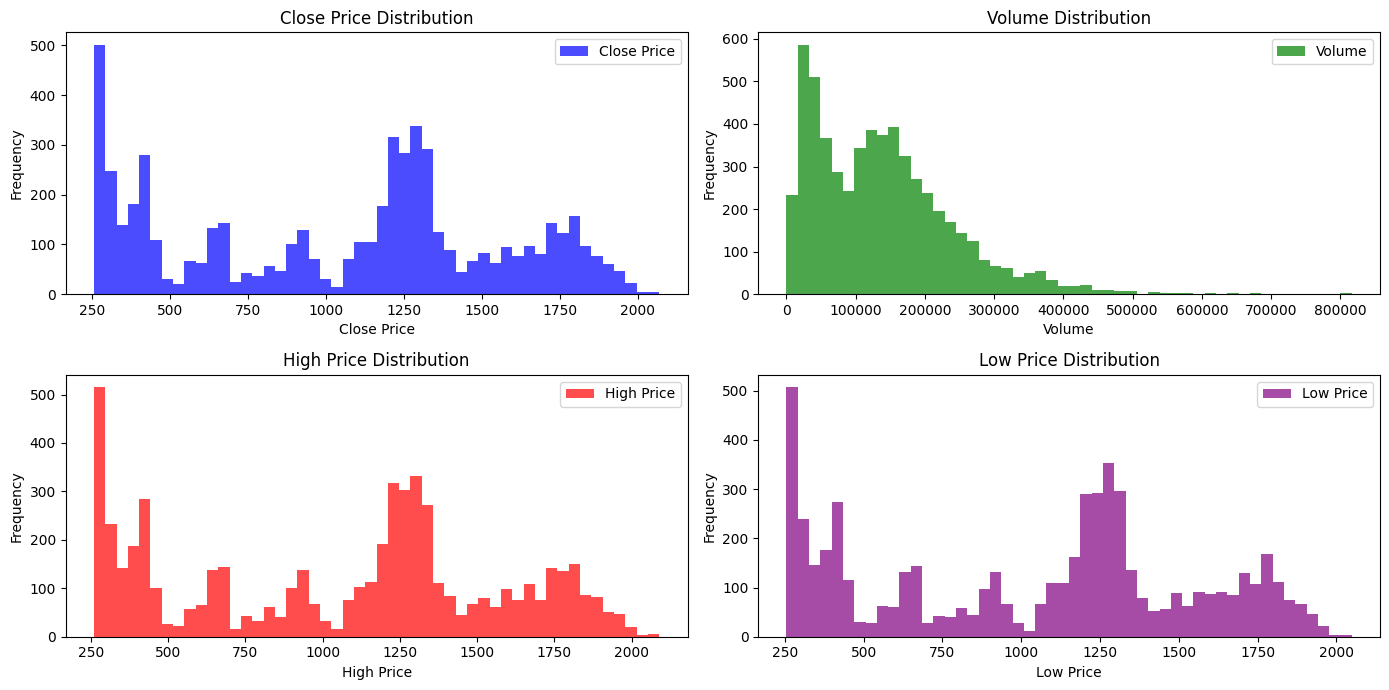

In [21]:
import matplotlib.pyplot as plt

# Collect data for plotting (ensure that column names are correct)
volume_data = df.select("Volume").rdd.flatMap(lambda x: x).collect()
open_data = df.select("Open").rdd.flatMap(lambda x: x).collect()  # Corrected column name from "OPen" to "Open"
close_data = df.select("Close").rdd.flatMap(lambda x: x).collect()
high_data = df.select("High").rdd.flatMap(lambda x: x).collect()
low_data = df.select("Low").rdd.flatMap(lambda x: x).collect()

# Plotting histograms
plt.figure(figsize=(14, 7))  # Increase figure size for better readability

# First plot: Close Price Distribution
plt.subplot(2, 2, 1)  # 2x2 grid, first subplot
plt.hist(close_data, bins=50, color='blue', alpha=0.7, label='Close Price')
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.legend()

# Second plot: Volume Distribution
plt.subplot(2, 2, 2)  # 2x2 grid, second subplot
plt.hist(volume_data, bins=50, color='green', alpha=0.7, label='Volume')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

# Third plot: High Price Distribution
plt.subplot(2, 2, 3)  # 2x2 grid, third subplot
plt.hist(high_data, bins=50, color='red', alpha=0.7, label='High Price')
plt.title('High Price Distribution')
plt.xlabel('High Price')
plt.ylabel('Frequency')
plt.legend()

# Fourth plot: Low Price Distribution
plt.subplot(2, 2, 4)  # 2x2 grid, fourth subplot
plt.hist(low_data, bins=50, color='purple', alpha=0.7, label='Low Price')
plt.title('Low Price Distribution')
plt.xlabel('Low Price')
plt.ylabel('Frequency')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


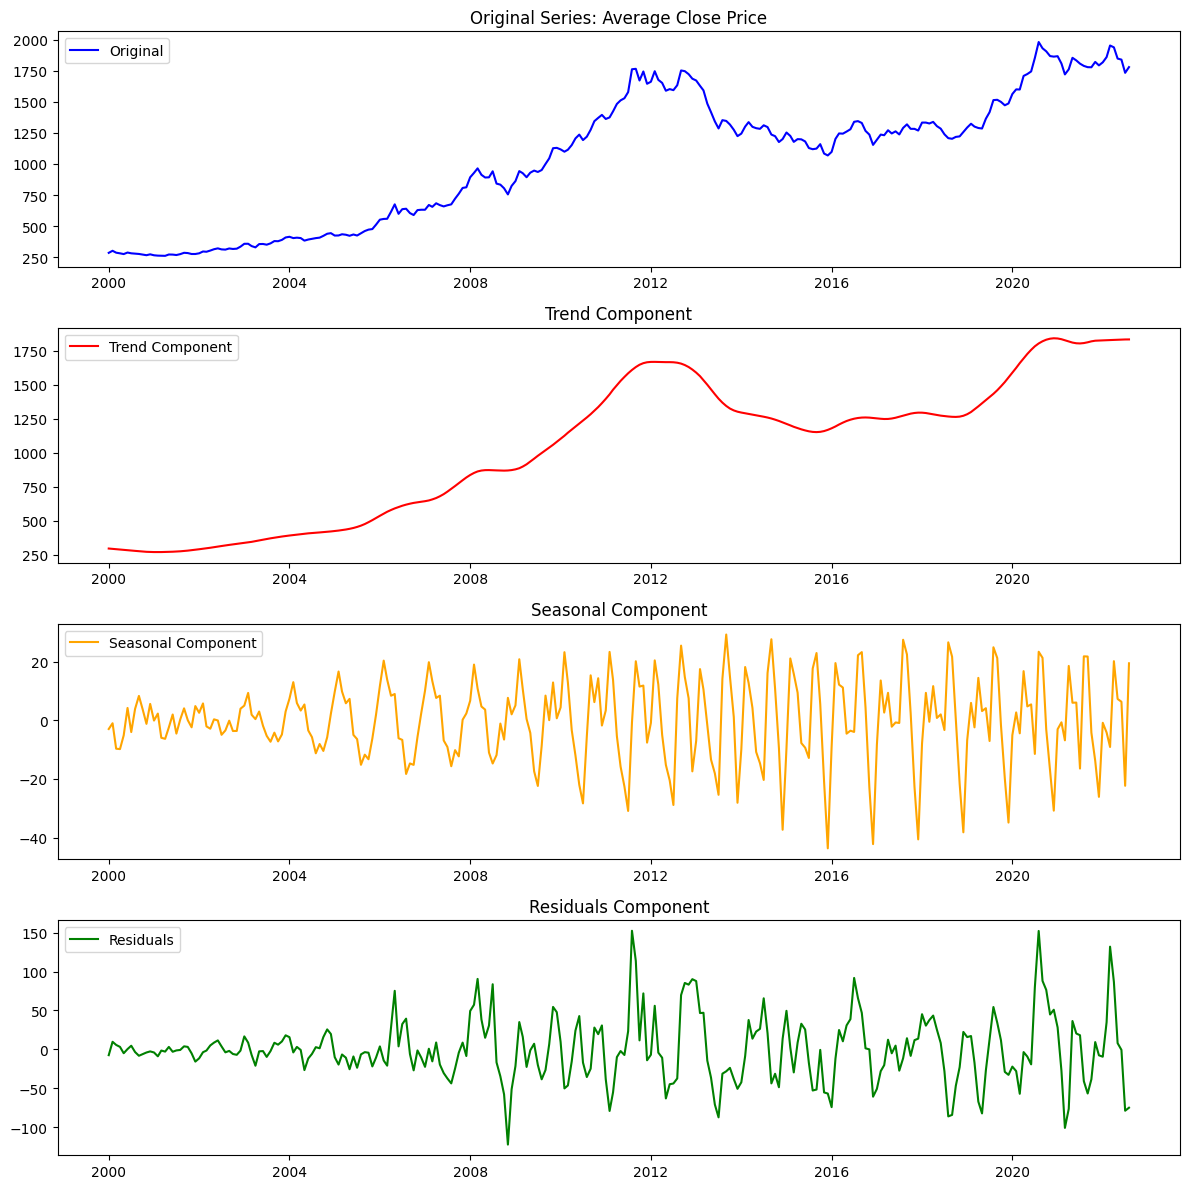

In [22]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Step 1: Extract Year and Month
df_with_year_month = df.withColumn("Year", F.year("Date")).withColumn("Month", F.month("Date"))

# Step 2: Group by Year and Month to calculate the monthly average Close for each year
df_monthly_avg = df_with_year_month.groupBy("Year", "Month").agg(F.avg("Close").alias("AvgClose"))

# Step 3: Sort by Year and Month for proper time series alignment
df_monthly_avg_sorted = df_monthly_avg.orderBy("Year", "Month")

# Step 4: Convert to Pandas DataFrame for time series analysis
df_monthly_avg_pd = df_monthly_avg_sorted.toPandas()

# Step 5: Create a datetime index to represent the time series
df_monthly_avg_pd['Date'] = pd.to_datetime(df_monthly_avg_pd['Year'].astype(str) + '-' + df_monthly_avg_pd['Month'].astype(str) + '-01')
df_monthly_avg_pd.set_index('Date', inplace=True)

# Step 6: Perform Seasonal Decomposition using STL (Seasonal-Trend decomposition using LOESS)
stl = STL(df_monthly_avg_pd['AvgClose'], seasonal=13)  # seasonal period of 12 months (monthly data)
result = stl.fit()

# Step 7: Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

# Plot the original series
ax1.plot(df_monthly_avg_pd['AvgClose'], label="Original", color='blue')
ax1.set_title('Original Series: Average Close Price')
ax1.legend()

# Plot the trend component
ax2.plot(result.trend, label="Trend Component", color='red')
ax2.set_title('Trend Component')
ax2.legend()

# Plot the seasonal component
ax3.plot(result.seasonal, label="Seasonal Component", color='orange')
ax3.set_title('Seasonal Component')
ax3.legend()

# Plot the residual component
ax4.plot(result.resid, label="Residuals", color='green')
ax4.set_title('Residuals Component')
ax4.legend()

plt.tight_layout()
plt.show()


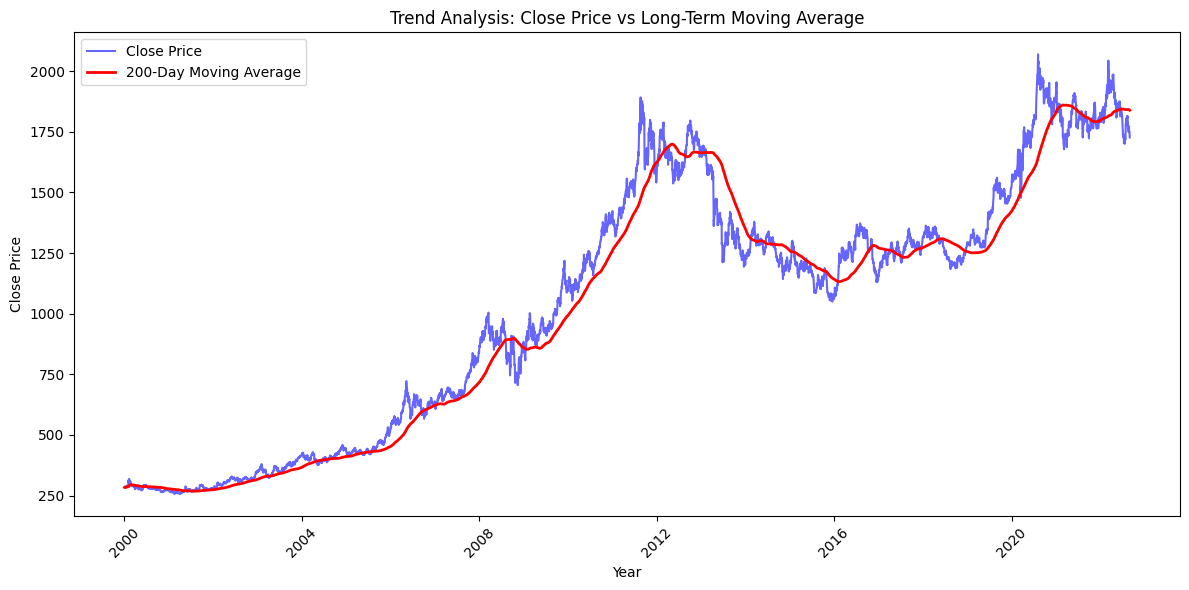

In [23]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Define the window specification for the long-term moving average
window_spec = Window.orderBy("Date").rowsBetween(-199, 0)

# Calculate the Long-Term Moving Average (RollingMA)
df_with_trend = df.withColumn("LongTermMA", F.avg("Close").over(window_spec))

# Collecting the data into a Pandas DataFrame for plotting
df_pd = df_with_trend.select("Date", "Close", "LongTermMA").toPandas()

# Plotting the Close price and Long-Term Moving Average
plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['Close'], label="Close Price", color="blue", alpha=0.6)
plt.plot(df_pd['Date'], df_pd['LongTermMA'], label="200-Day Moving Average", color="red", linewidth=2)
plt.title('Trend Analysis: Close Price vs Long-Term Moving Average')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Filtered data count: 5701
+---------------+------------------+
|DayOfWeek_Index|          AvgClose|
+---------------+------------------+
|              1|1018.3037769784169|
|              3|1043.8248281786937|
|              4|1038.8235975066793|
|              2|1039.6021294718912|
|              0|1059.3360815602837|
+---------------+------------------+

   DayOfWeek_Index     AvgClose
0                0  1059.336082
1                1  1018.303777
2                2  1039.602129
3                3  1043.824828
4                4  1038.823598


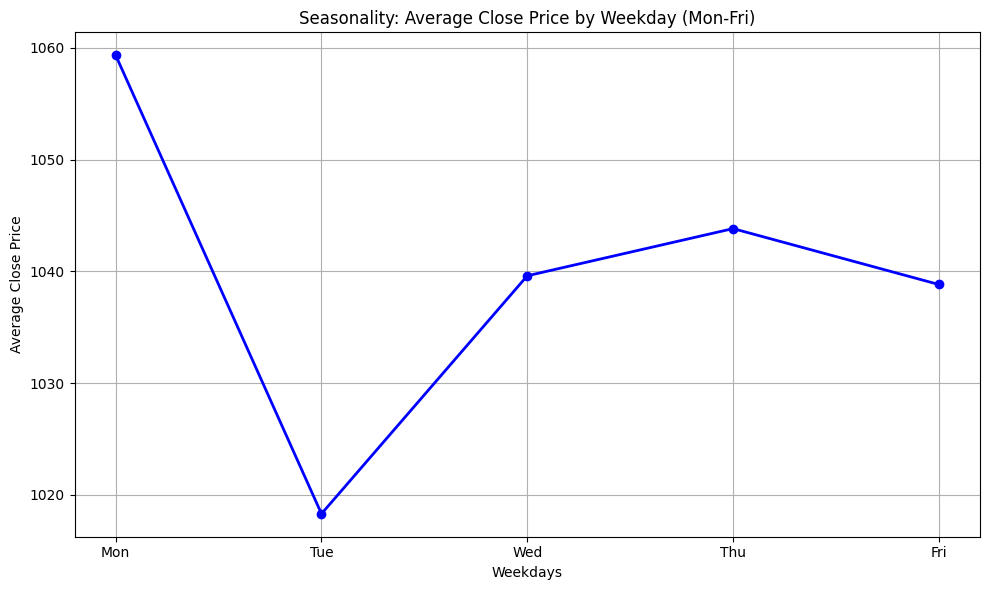

In [24]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType  # Correct import
import matplotlib.pyplot as plt

# Map DayOfWeek strings to numerical values
day_of_week_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4
}

# Create a UDF to map the DayOfWeek column to numerical values
def map_day_of_week(day_str):
    return day_of_week_map.get(day_str, -1)  # Return -1 if it's not a valid day

# Register the UDF with PySpark
map_day_of_week_udf = F.udf(map_day_of_week, IntegerType())  # Use IntegerType from pyspark.sql.types

# Apply the UDF to the DayOfWeek column to convert it to numeric values
df_with_numeric_day = df.withColumn("DayOfWeek_Index", map_day_of_week_udf(df["DayOfWeek"]))

# Filter the data to include only Monday to Friday (DayOfWeekNumeric 0 to 4)
df_weekdays = df_with_numeric_day.filter(df_with_numeric_day["DayOfWeek_Index"].between(0, 4))

# Check if the filtered DataFrame is non-empty
print(f"Filtered data count: {df_weekdays.count()}")

# Group by DayOfWeekNumeric (Mon=0, Tue=1, ..., Fri=4) and calculate average Close price for each weekday
df_weekly_avg = df_weekdays.groupBy("DayOfWeek_Index").agg(F.avg("Close").alias("AvgClose"))

# Show the grouped result
df_weekly_avg.show()

# Collect the results into a Pandas DataFrame for plotting
df_weekly_avg_pd = df_weekly_avg.orderBy("DayOfWeek_Index").toPandas()

# Check if the Pandas DataFrame contains data before plotting
print(df_weekly_avg_pd)

# Plotting the results to visualize weekly seasonality
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_avg_pd['DayOfWeek_Index'], df_weekly_avg_pd['AvgClose'], marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Seasonality: Average Close Price by Weekday (Mon-Fri)')
plt.xlabel('Weekdays')
plt.ylabel('Average Close Price')
plt.xticks(ticks=range(5), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.grid(True)
plt.tight_layout()
plt.show()


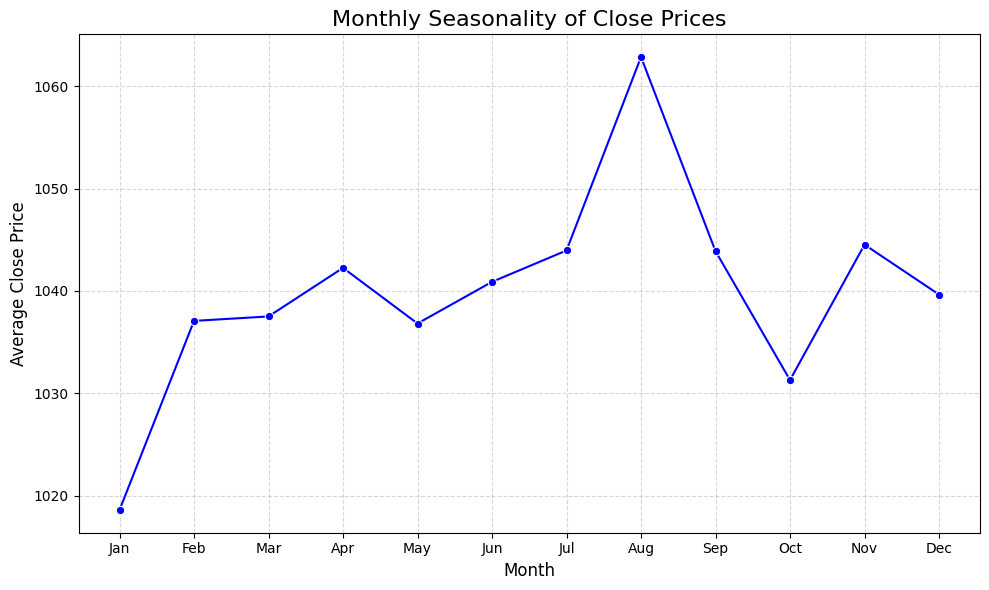

In [ ]:
from pyspark.sql.functions import month, year, avg, col
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Date is in proper datetime format
df = df.withColumn("Date", col("Date").cast("date"))

# Extract year and month from the Date column
df = df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))

# Calculate the average Close price for each month over all years
monthly_trend = df.groupBy("Month").agg(avg("Close").alias("Avg_Close")).orderBy("Month")

# Collect the results for plotting
monthly_trend_data = monthly_trend.toPandas()  # Convert to Pandas for easy plotting

# Plot the monthly seasonality trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_data, x="Month", y="Avg_Close", marker="o", color="blue")

# Add plot details
plt.title("Monthly Seasonality of Close Prices", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Close Price", fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
from pyspark.ml.regression import LinearRegression

# Example: Predicting Close Price using other columns
lr = LinearRegression(featuresCol="features", labelCol="Close")
lr_model = lr.fit(df_vector)
lr_summary = lr_model.summary
print("R2:", lr_summary.r2)


R2: 1.0


The result R2: 1.0 means that the R-squared value (R²) of your linear regression model is 1.0. This indicates a perfect fit of the model to the data, meaning that the model explains 100% of the variance in the Close price using the other features in your dataset.

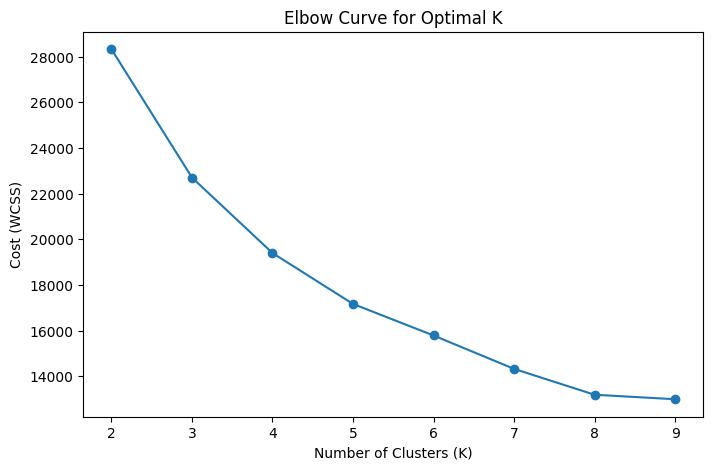

+-----+------+----------+---------+----------+----------+
|Close|Volume|PriceRange|LogReturn|Volatility|prediction|
+-----+------+----------+---------+----------+----------+
|283.7| 21621|       9.5|      0.0|       0.0|         1|
|282.1| 25448|       4.0| -0.00566|      1.13|         1|
|282.4| 19055|       2.6|  0.00106|      0.85|         1|
|282.9| 11266|       2.5|  0.00177|       0.7|         1|
|282.7| 30603|       2.1|  -7.1E-4|      0.61|         1|
|284.4| 13500|       3.4|    0.006|      0.86|         1|
|283.7| 17841|       2.5| -0.00246|      0.83|         1|
|285.1| 12171|       3.0|  0.00492|      1.03|         1|
|284.9| 32339|       1.6|  -7.0E-4|      1.09|         1|
|289.6| 28615|       3.9|  0.01636|      2.17|         1|
|290.3| 24097|       3.5|  0.00241|      2.77|         1|
|289.3| 20707|       2.3| -0.00345|      2.96|         1|
|289.7| 25726|       2.9|  0.00138|      3.11|         1|
|288.1| 32140|       3.4| -0.00554|      3.07|         1|
|286.6| 36122|

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Step 3: Assemble Features
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn",
                "DailyChange%", "ShortMA", "LongMA", "Volatility"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Step 4: Standardize Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Step 5: Compute the Cost for Elbow Curve
cost = []
K_values = range(2, 10)
for k in K_values:
    kmeans = KMeans(k=k, seed=42).setFeaturesCol("scaled_features")
    model = kmeans.fit(df)
    cost.append(model.summary.trainingCost)

# Step 6: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, cost, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost (WCSS)")
plt.title("Elbow Curve for Optimal K")
plt.show()

# Step 7: Train KMeans with the Optimal K
optimal_k = 4  # Replace with your chosen K based on the elbow curve
kmeans = KMeans(k=optimal_k, seed=42).setFeaturesCol("scaled_features")
model = kmeans.fit(df)

# Step 8: Add Cluster Predictions to the DataFrame
clustered_df = model.transform(df)

# Step 9: Show the Clustered Data
clustered_df.select("Close", "Volume", "PriceRange", "LogReturn", "Volatility", "prediction").show()


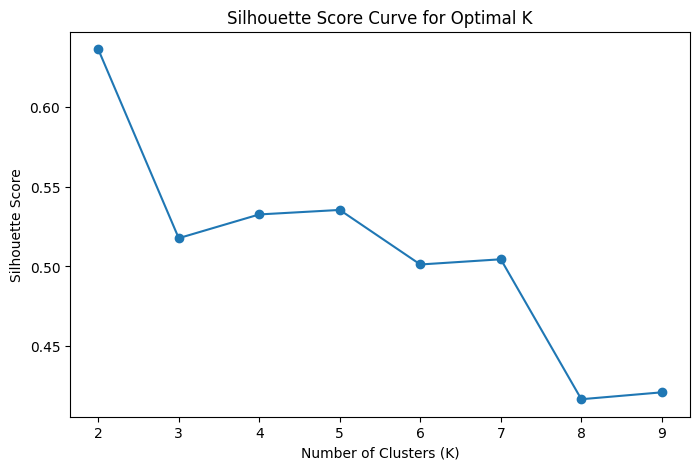

+-----+------+----------+---------+----------+----------+
|Close|Volume|PriceRange|LogReturn|Volatility|prediction|
+-----+------+----------+---------+----------+----------+
|283.7| 21621|       9.5|      0.0|       0.0|         1|
|282.1| 25448|       4.0| -0.00566|      1.13|         1|
|282.4| 19055|       2.6|  0.00106|      0.85|         1|
|282.9| 11266|       2.5|  0.00177|       0.7|         1|
|282.7| 30603|       2.1|  -7.1E-4|      0.61|         1|
|284.4| 13500|       3.4|    0.006|      0.86|         1|
|283.7| 17841|       2.5| -0.00246|      0.83|         1|
|285.1| 12171|       3.0|  0.00492|      1.03|         1|
|284.9| 32339|       1.6|  -7.0E-4|      1.09|         1|
|289.6| 28615|       3.9|  0.01636|      2.17|         1|
|290.3| 24097|       3.5|  0.00241|      2.77|         1|
|289.3| 20707|       2.3| -0.00345|      2.96|         1|
|289.7| 25726|       2.9|  0.00138|      3.11|         1|
|288.1| 32140|       3.4| -0.00554|      3.07|         1|
|286.6| 36122|

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt


# Step 3:
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn",
                "DailyChange%", "ShortMA", "LongMA", "Volatility"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_temp")  # Changed output column name
df = assembler.transform(df)

# Step 4:
scaler = StandardScaler(inputCol="features_temp", outputCol="standardized", withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Drop the temporary 'features_temp' column to avoid conflicts
df = df.drop("features_temp")

# Step 5:
silhouette_scores = []
K_values = range(2, 10)

evaluator = ClusteringEvaluator(predictionCol="prediction",
                                featuresCol="standardized",
                                metricName="silhouette",
                                distanceMeasure="squaredEuclidean")

for k in K_values:

    kmeans = KMeans(k=k, seed=42).setFeaturesCol("standardized")
    kmeans_model = kmeans.fit(df)


    predictions = kmeans_model.transform(df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

# Step 6:
plt.figure(figsize=(8, 5))
plt.plot(K_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Curve for Optimal K")
plt.show()

# Step 7:
optimal_k = 4
kmeans = KMeans(k=optimal_k, seed=42).setFeaturesCol("standardized")
final_model = kmeans.fit(df)

# Step 8:
clustered_df = final_model.transform(df)

# Step 9:
clustered_df.select("Close", "Volume", "PriceRange", "LogReturn", "Volatility", "prediction").show()


+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+--------------------+----------+
|      Date| Open| High|  Low|Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA|LongMA|Volatility|DayOfWeek|            features|prediction|
+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+--------------------+----------+
|2000-01-04|289.5|289.5|280.0|283.7| 21621|       9.5|      0.0|         0.0|  283.7| 283.7|       0.0|  Tuesday|[283.7,21621.0,0....|         1|
|2000-01-05|283.7|285.0|281.0|282.1| 25448|       4.0| -0.00566|       -0.56|  282.9| 282.9|      1.13|Wednesday|[282.1,25448.0,-0...|         1|
|2000-01-06|281.6|282.8|280.2|282.4| 19055|       2.6|  0.00106|        0.11| 282.73|282.73|      0.85| Thursday|[282.4,19055.0,0....|         1|
|2000-01-07|282.5|284.5|282.0|282.9| 11266|       2.5|  0.00177|        0.18| 282.78|282.78|       0.7|   Friday|[282.9,1126

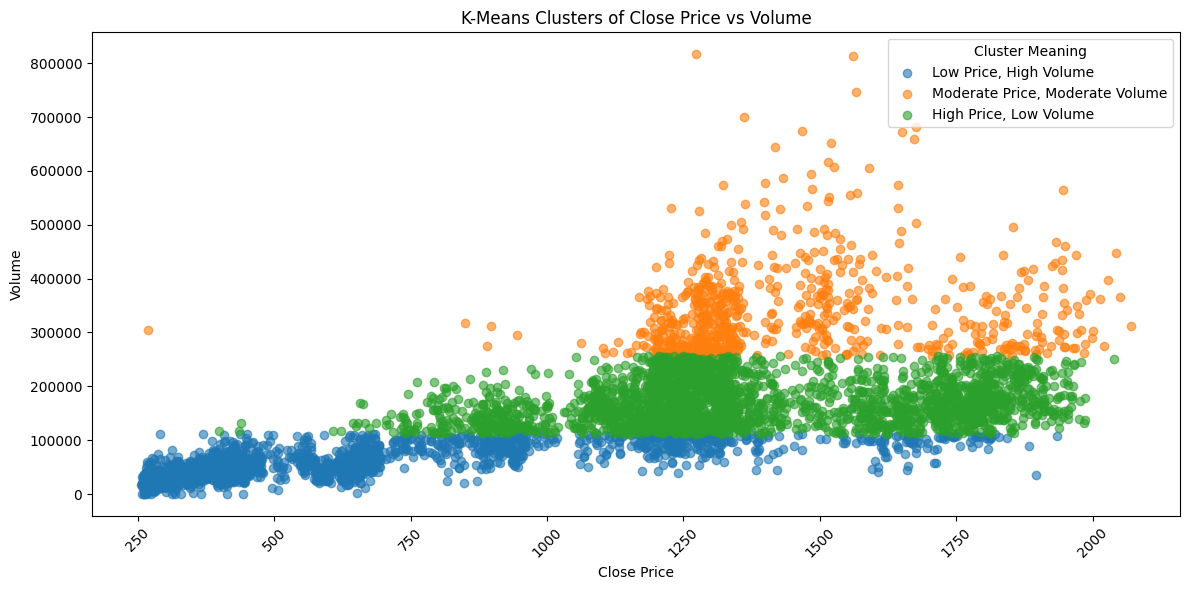

In [28]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Example: K-means clustering for market behavior
kmeans = KMeans(k=3, seed=1, featuresCol="features")
model = kmeans.fit(df_vector)
predictions = model.transform(df_vector)
predictions.show()


# Collect data into Pandas DataFrame
df_pd = predictions.select("Date", "Close", "Volume", "prediction").toPandas()

# Define custom cluster labels based on the characteristics of each cluster
# These labels are just examples, adjust them based on your analysis
cluster_labels = {
    0: "High Price, Low Volume",  # Example label for cluster 0
    1: "Low Price, High Volume",  # Example label for cluster 1
    2: "Moderate Price, Moderate Volume"  # Example label for cluster 2
}

# Create a scatter plot
plt.figure(figsize=(12, 6))

# Plot each cluster with different colors and labels
for cluster_id in df_pd['prediction'].unique():
    cluster_data = df_pd[df_pd['prediction'] == cluster_id]
    plt.scatter(cluster_data['Close'], cluster_data['Volume'], label=cluster_labels[cluster_id], alpha=0.6)

# Adding labels and title
plt.title('K-Means Clusters of Close Price vs Volume')
plt.xlabel('Close Price')
plt.ylabel('Volume')

# Add legend
plt.legend(title='Cluster Meaning')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
spark.stop()